# KVN, Margaret & bingo - Part 3
> Third part of a (hopefully) friendly introduction to Neural Networks and their capabilities. In this part, we will succesfully train a Neural Network with Python Keras to recognize handwritten digits.

- toc: true 
- badges: false
- comments: true
- categories: [machine learning]

In [Part 1](https://bepuca.dev/machine%20learning/2020/05/24/kvn-part-1.html), we defined what we are trying to achieve (KVN whispering Margaret the drawn numbers) and what our proposed solution (a Neural Network).

In [Part 2](https://bepuca.dev/machine%20learning/2020/06/04/kvn-part-2.html), we introduced the key concepts for KVN to be able to learn anything at all: loss functions, gradient descent and backpropagation.

Now it is time to start building the system we want to implement into KVN! To do so, we will use the **Keras** Python library. This library is specially designed to ease the creation and implementation of neural networks. Most of the things discussed above are already implemented in the library's methods. Let's start by loaing everything we will need.

> Important: Even though we will use Python to implement the concepts, I aim to explain them in a way everyone can get the gist.

In [167]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Load the data
First of all, we need some examples for KVN to learn. Recall that we intend to make KVN learn by showing him examples of handwritten digits and telling him what number they represent. The set of examples used for learning are called the **training set**. Moreover, we also need some other examples that we can show KVN to evaluate him before the big night so we are sure he will deliver. These examples are called the **test set**.

Therefore, we need images of handwritten digits that we can show KVN so he can start learning. There is an extensively used public dataset called the [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits. This dataset contains a training set of 60000 examples and a test set of 10000 examples. Luckily for us, this dataset is already implemented in the Keras library so we can directly use it!

In [168]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


As we can see, the training input set *X_train* contains 60000 greyscale images of size 28x28 px. The training label set *y_train* contains 60000 labels corresponding to each image. Let's look at some of the samples:

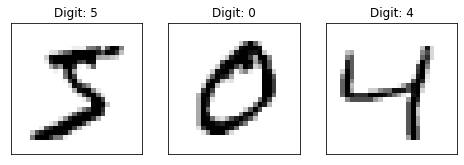

In [169]:
# Plot some MNIST examples.
plt.figure(figsize=(8,2.5))
for i in range(3):
    plt.subplot(131+i)
    plt.imshow(X_train[i], cmap='gray_r')
    plt.title(f"Digit: {y_train[i]}")
    plt.xticks([])
    plt.yticks([])

## Format the data

As expected, these images are just what we need for KVN to learn to assist Margaret! Now, in order to use the images in the Keras implementation of the system, they have to be formatted in a particular manner (defined by the Keras library)::
- Each pixel value goes from 0 to 255, but inputs need to be between 0 and 1. 
- The inputs must be vectors, not matrices.

    28x28 px -> 784x1 px
    
There are ten categories which correspond to digits from $0$ to $9$.

In [170]:
# Format the data shape.
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Change data type.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Normalize inputs to 0-1 interval.
X_train /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


## Build the neural network
Now that we have the data, we need to **build** the system that we will implement to KVN, we need to build the neural network! So far, the only network that we have seen had one (dummy) input layer, one hidden layer and one output layer. There are different types of layers. The one that is fully connected to the previous and the next layer (as the ones we have seen) is called **Dense** in Keras. For now, we will stick to this simple **architechture** (i.e. network structure) and see if it works. That is, our neural network will be constituted by:

1. An input layer with $784$ inputs (one per pixel).

2. A hidden Dense layer with $n=30$ neurons.

    - Activation function: sigmoid
    
    
3. An output Dense layer with $n=10$ neurons.

    - Activation function: sigmoid
    
The choice of $n=30$ neurons in the hidden layer is rather arbitrary. Nonetheless, the number of neurons on the output layer is directly related to the number of categories we want for KVN to learn. Since we have $10$ categories (digits), we need $10$ neurons. The idea is that KVN's guess will be related to the neuron that has the higher activation. If the neuron corresponding to the digit 3 is the one with the higher activation, KVN is saying: *"A 3!"*.

Keras allows us to build our neural network in a very intuitive way. We generate what is called a *Sequential* model that basically lets us to add layers sequentially. When we add layers, there are ways to initialize the weights and biases (i.e. the parameter set) with different distributions. Nonetheless, we won't focus on this. Despite that, know that the initialization can influence the learning procedure. This makes sense since the initialization determines where in the mountain we start our downhill!

Enough chit chat, let's build KVN's system!

In [171]:
# Define KVN's system.
kvn = keras.Sequential(name='KVN_system')

# Add the hidden layer, a Dense layer with 30 neurons.
# The first layer also requires specification of input dimensions.
# Specify the activation function of the neurons too.
kvn.add(layers.Dense(30, input_shape=(784,), activation='relu', name='hidden'))

# Add the output layer, a Dense layer with 10 neurons (1 neuron per category).
kvn.add(layers.Dense(10, activation='sigmoid', name='output'))

# Save the initial weights and biases.
kvn.save_weights('kvn_init_weights.h5')

Keras also allows us to check that we built the system we want. Here's how:

In [172]:
kvn.summary()

Model: "KVN_system"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 30)                23550     
_________________________________________________________________
output (Dense)               (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


## Insert system into KVN
Now that we have defined our system, we plug it into KVN. In actual terms, we **compile** the model (we won't delve into that either). The only thing that we need to know is that we need to specify the loss function (measure of how wrong KVN is), the optimizer (KVN's learning method) we want to use in the system and which metrics we want to get (the accuracy of KVN's predictions).

In [173]:
# Compile the model.
kvn.compile(
    # Loss function (wrongness meter). 
    loss='sparse_categorical_crossentropy',
    # Optimizer (learning method).
    optimizer='sgd',
    # Result evaluation.
    metrics=['accuracy']
)

## KVN, learn!
Now that we have plugged the system into KVN it is time to start showing him the images of the numbers. 60000 of them. This phase is usually called the model **fit** because we are fitting all parameters to minimize the cost function. The **validation set** specified here answers to a similar idea as the test set. We have a set of examples to validate how KVN's is doing during the learning phase. 

> Tip: For proper development, we would want a validation set _and_ a test set. Validation sets are used to try different strategies and asses which one is best during training. The test set should only be used at the end to provide an idea on how good KVN will work in the real situation.

Let's learn!

In [174]:
batch_size = 64 # Number of training examples in each mini-batch.
epochs = 10     # Number of epochs.

# Fit the model and store information in history.
history = kvn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

## KVN, test time!
After this training session, KVN should have learned something. Now we want to see what has he learnt. To do so, let's evaluate KVN. Let's show him the test images (which he didn't use to learn although we already used them to see how he was doing) and see how good is he at identifying the digit present.

In [175]:
# Evaluate the performance of the system with the test set.
scores = kvn.evaluate(X_test, y_test, verbose=0)

# Scores contain the specified metrics.
print("Test loss:", scores[0])     # Loss function by default.
print("Test accuracy:", scores[1]) # Accuracy as asked.

Test loss: 0.2650674283504486
Test accuracy: 0.9253000020980835


Damn, KVN! This is a remarkably good result! An accuracy of over $0.90$ means that KVN got the digit right more than $90 \%$ of the time. This is quite a feature!

Let's check some of the KVN's good guesses and some of the KVN's bad guesses to get a flavor of what he has learned.

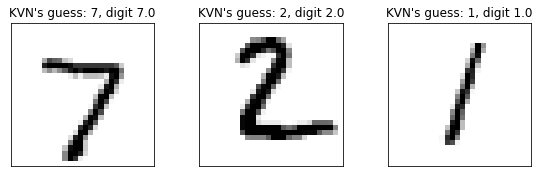

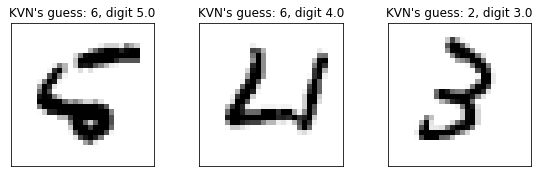

In [176]:
# Get the predicted class for each sample in X_test.
predicted_classes = np.argmax(kvn.predict(X_test), axis=-1)

# Check which are the good guesses and the bad guesses.
correct_indexes = np.nonzero(y_test == predicted_classes)[0]
incorrect_indexes = np.nonzero(y_test != predicted_classes)[0]

# And see some examples.
# Good guesses (predictions).
plt.figure(figsize=(8,2.5))
for i, idx in enumerate(correct_indexes[:3]):
    plt.subplot(131+i)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray_r')
    plt.title(f"KVN's guess: {predicted_classes[idx]}, digit {y_test[idx]}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
    
# Bad guesses (predictions).
plt.figure(figsize=(8,2.5))  
for i, idx in enumerate(incorrect_indexes[:3]):
    plt.subplot(131+i)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray_r')
    plt.title(f"KVN's guess: {predicted_classes[idx]}, digit {y_test[idx]}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

Well, as we can see above, KVN got trouble learning to identify digits of rather poor handwritting but correctly identified more standard ones. So, for now, I think we can say that KVN did a good job!

Okay okay, good compared to what? The most trivial system would be to randomly pick a class. That is, that when we show KVN an image he randomly says a digit. In that case, he will be right, on average, $10 \%$ of the time (because we have $10$ classes). So our system is quite better than the random system! Nonetheless, *how good is the accuracy* heavily depends on the problem. If we were trying to identify if a patient has cancer, for instance, this accuracy might still be too low. For the case at hand, that accuracy will absolutely do for good old Margaret.

KVN got a cookie!

![](kvn/kvn_cookie.jpg "KVN and his well-deserved cookie.")

## Did we get lucky?

As you might have realized, I made some *arbitrary* choices regarding some of the parameters such as the the number of neurons in the hidden layer or the epochs trained. Will KVN always perform that good independently of the choices we make? The short answer is no.

In the next (and final part), we will discover some of the factors that can dramatically impact the learning capabilities and performance of neural networks. We will talk about hyperparameters and regularization.

- [Part 1](https://bepuca.dev/machine%20learning/2020/05/24/kvn-part-1.html): Definition of Neural Networks at the problem at hand. Friendly context introduction.

- [Part 2](https://bepuca.dev/machine%20learning/2020/06/01/kvn-part-2.html): The training building blocks: loss functions, gradient descent and backpropagation.